In [1]:
if "siteName" not in globals():
    siteName = "Virginia Beach"
    Hs,Tp,A,U = (2, 8, 0.5, 0.5)

In [ ]:
import os
import sys
from contextlib import contextmanager

# ChatGPT5 Oct 27 2025: In python I am using a module that calls a C executable. The module prints lots of text to stdout and stderr. How can I wrap the relevant commands in python to suppress this output?

@contextmanager
def suppress_c_output():
    sys.stdout.flush()
    sys.stderr.flush()
    devnull = os.open(os.devnull, os.O_WRONLY)
    old_stdout = os.dup(1)
    old_stderr = os.dup(2)
    os.dup2(devnull, 1)
    os.dup2(devnull, 2)
    try:
        yield
    finally:
        os.dup2(old_stdout, 1)
        os.dup2(old_stderr, 2)
        os.close(devnull)
        os.close(old_stdout)
        os.close(old_stderr)

# Example:
#with suppress_c_output():

In [1]:
# at some point the trigonometric version stopped working with x,y from geopandas
# I got the below code from ChatGPT5 on Oct 28 2025 using the prompt "I have geodataframes where I need to reorient the coordinates to minimize the variance in y. Can I use a custom projection?" 

from shapely.affinity import rotate

def rotate_gdf(gdf,angle=None,coords=None):
    if angle==None and coords==None:
        # Suppose gdf is your GeoDataFrame, with geometry in a planar CRS
        geom = gdf.union_all()  # combine all geometries
        coords = np.array(list(geom.coords))
    if angle==None:
        # Compute mean-centered coordinates
        coords_centered = coords - coords.mean(axis=0)
        
        # Covariance and eigen-decomposition
        cov = np.cov(coords_centered.T)
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # The eigenvector with the largest eigenvalue = direction of greatest variance
        # Compute rotation angle (in degrees)
        major_axis = eigvecs[:, np.argmax(eigvals)]
        angle = np.degrees(np.arctan2(major_axis[1], major_axis[0]))
    #TODO accept coords as input (output as coords?)
    # Rotate geometries so major axis aligns with x (subtract angle)
    gdf_rotated = gdf.copy()
    gdf_rotated["geometry"] = gdf_rotated.geometry.apply(lambda g: rotate(g, -angle, origin='center'))

    return gdf_rotated, angle

In [2]:
# Copied only the used functions from https://github.com/csdms-espin/coastal2025/blob/main/scripts/cem_utils.py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib import path
# from scipy.spatial import cKDTree
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

# TODO: Unit test and remove; at some point this stopped working with my geopandas workflow
# def rotate_shoreline(x,y,angle='auto'):
#     '''This function takes points (x,y) and rotates them by an angle
#     The angle is automatically generated by the end points of the shorelines coordinates
#     If this approach doesnt work for some reason you may input an angle maually (in degrees).'''
    
#     if angle == 'auto':
#         sign = -1 if y[-1]>y[0] else 1
#         a = sign*np.arctan((y[-1]-y[0])/(x[-1]-x[0]))
#     else:
#         a = angle*np.pi/180
#     # using this rotation matix
#     xnew = (x ) * np.cos(a) - (y ) * np.sin(a)  
#     ynew = (x ) * np.sin(a) + (y ) * np.cos(a) 
#     return xnew,ynew,np.degrees(a)

def fill_gaps(x, y, max_gap):
    x = np.array(x)
    y = np.array(y)
    
    x_filled = []
    y_filled = []

    for i in range(len(x) - 1):
        # Always include the current point
        x_filled.append(x[i])
        y_filled.append(y[i])

        # Compute the gap
        gap = x[i+1] - x[i]

        if gap > max_gap:
            # Number of new points to insert
            num_new = int(np.floor(gap / max_gap))

            # Generate new x values
            new_x = np.linspace(x[i], x[i+1], num=num_new+2)[1:-1]
            new_y = np.linspace(y[i], y[i+1], num=num_new+2)[1:-1]

            x_filled.extend(new_x)
            y_filled.extend(new_y)

    # Don't forget the last point
    x_filled.append(x[-1])
    y_filled.append(y[-1])

    return np.array(x_filled), np.array(y_filled)

def plot_coast(domain,dx,dy,fig=None,ax=None):
    '''Plot the coastline.
    
    Inputs:
    ------
    domain = any 2D array (though colorbar label is specific for water depth)
    
    '''
    N,M = domain.shape
    s = M/N
    if fig==None:
        fig,ax = plt.subplots(figsize=(int(s*8),7))
    im = ax.imshow(domain, origin='lower', cmap='viridis')
    if not any(a.get_label() == '<colorbar>' for a in fig.axes[:]):
        cb = ax.figure.colorbar(im, ax=ax, pad=0.01)# fraction=0.05,
        cb.ax.tick_params(labelsize=15)
        cb.set_label('Water Depth (m)', fontsize=18, rotation=270, labelpad=30)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size=0.05, pad=0.05)
    # cb = fig.colorbar(im,cax=cax)
    # cb.ax.tick_params('both',labelsize=15)
    # cb.ax.set_ylabel('Water Depth (m)',fontsize=18,rotation=-90, labelpad=30)
    y = np.linspace(0,N,4)
    x = np.linspace(0,M,4)
    Y = (y*dy/(1000)).astype('int')
    X = np.asarray(x*dx/(1000)).astype('int')
    ax.set_yticks(y)
    ax.set_xticks(x)
    ax.set_yticklabels(Y)
    ax.set_xticklabels(X)
    ax.set_xlabel('Along shore (km)',fontsize=20)
    ax.set_ylabel('Cross shore (km)',fontsize=20)
    ax.tick_params('both',labelsize=15)
    return im

def initialize_models(params,domain,cem,waves,set_land):
    '''
    Inputs:
    ------
    
    -params = parameter dictionary
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
            
    '''
    p = params
    
    N,M = domain.shape

    args = cem.setup( number_of_rows = N , number_of_cols = M, 
                  grid_spacing = p['grid_spacing'] ,  shelf_slope = p['shelf_slope'] , 
                  shoreface_depth = p['shoreface_depth'] , shoreface_slope = p['shoreface_slope']
                )

    waves.initialize(*waves.setup())
    cem.initialize(*args)
    
    waves.set_value('sea_surface_water_wave__height', p['wave_height']);
    waves.set_value('sea_surface_water_wave__period',p['wave_period']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter',
                   p['wave_angle_highness']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter',
                   p['wave_angle_asymmetry']);

    if set_land==True: #if need set land elevation; 'False' used default
        cem.set_value('land_surface__elevation',domain.flatten());
    cem.set_value('model__time_step', float(p['model__time_step']));

def run_model_loop(time_years, domain ,cem ,waves, qs_3,animate,update_ani_years):
    '''Loop to run the cem-waves models.
    This loop only couples the wave angles and will need to be changed to add additional coupling.
    It also assumes static variables such as sediment input and would need modification to update such variables.
    
    Inputs:
    ------
    
    -time_years = time you want to run the model in years
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
        
    '''

    alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
    update_ani = int(365*update_ani_years/cem.get_value('model__time_step'))
    T = int(365*time_years/cem.get_value('model__time_step'))
    dx,dy = cem.grid_spacing(cem.var_grid('sea_water__depth'))
    for time in range(T):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        cem.set_value("land_surface_water_sediment~bedload__mass_flow_rate", np.array(qs_3[:,:,time]))
        cem.update()
        if animate:
            if time%update_ani == 0 or time==T-1:
                clear_output(wait=True)
                plot_coast(cem.get_value('land_surface__elevation').reshape(domain.shape),dx,dy)
                plt.title('Time : '+ str(round((time*cem.get_value('model__time_step')/365)[0],1)) +' years',fontsize=20)
                plt.show()

        else:
            clear_output(wait=True)
            print('Time Step: ',time, ' days')

In [3]:
def vid_model_loop(time_years, domain ,cem ,waves, qs_3,animate,update_ani_years):
    '''Loop to run the cem-waves models.
    This loop only couples the wave angles and will need to be changed to add additional coupling.
    It also assumes static variables such as sediment input and would need modification to update such variables.
    Inputs:
    ------
    -time_years = time you want to run the model in years
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1]
                -->> 1 = land, <1 = water
    -cem,waves = the imported models
        --->ex: cem = pymt.Cem()
    '''
    alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
    update_ani = int(365*update_ani_years/cem.get_value('model__time_step')[0])
    T = int(365*time_years/cem.get_value('model__time_step')[0])
    dx,dy = cem.grid_spacing(cem.var_grid('sea_water__depth'))
    i=0
    ims = []
    N,M = domain.shape
    width = max(10, min(80, M/50))
    fig,ax = plt.subplots()#figsize=(8,4))
    fig.set_figwidth(width)
    # fig.subplots_adjust(right=0.15)
    # fig.text(0.25,0.95,siteName,fontsize=20)
    for time in range(T):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        cem.set_value("land_surface_water_sediment~bedload__mass_flow_rate", np.array(qs_3[:,:,time]))
        with suppress_c_output():
            cem.update()
        if animate:
            if time%update_ani == 0 or time==T-1:
                i+=1
                # clear_output(wait=True)
                # plt.sca(ax)
                ttll = plt.text(0, 1.01, siteName,fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
                ttlr = plt.text(0.95, 1.01, f"Time : {int(time*cem.get_value('model__time_step')[0]/365)+1:2d} yrs", fontsize=20, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
                # ttll = plt.title(siteName,loc='left',fontsize=20)
                # ttlr = plt.title(f"Time : {int(time*cem.get_value('model__time_step')[0]/365)+1:2d} yrs",loc='right',fontsize=20)
                im = plot_coast(cem.get_value('land_surface__elevation').reshape(domain.shape),dx,dy,fig,ax)
                ax.set_aspect(width/16)
                fig.tight_layout()
                # fig.subplots_adjust(left=0.15)#,right=0.85) # For some reason most plots need this but it's too unpredictable to automate
                pos = ax.get_position()
                for cax in fig.axes[:]:
                    if cax.get_label() == '<colorbar>':
                        cax.set_position([pos.x1+0.005, pos.y0, 0.02, pos.height])  #  x0, y0, width, height
                # fig.subplots_adjust(left=0.06, right=0.92, top=0.96, bottom=0.08)
                #plt.savefig(png_dir + str((round((time*cem.get_value('model__time_step')/365)[0],1))/1000) + '.png') #turn on when creating animation gif
                ims.append([im,ttll,ttlr])
        else:
            # clear_output(wait=True)
            print('Time Step: ',time, ' days')
    anim = ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=2000)
    return anim

In [4]:
def set_domain(elev, pad=20):
    z_elev = elev.T.copy() # transpose of the elevations for CEM/plotting purposes
    z_elev[z_elev==-5] = -1 ## -5 is the "shoreline" flag from above.
    domain = -1*z_elev ## we want the domain to have values above sea-level to be >0 and below <0

    # neighs = np.ones([10,10])
    # total = (10**2)
    # domain = signal.convolve2d(domain,neighs/total,mode='same',boundary='symm')

    # domain[z_elev==-1] = 5 ## our shoreline got smoothed out too. This fixes that and makes sure our land is at 1m above sea level

    mat = []
    N,M = domain.shape
    for i in range(0,N):
        for j in range(0,M):
            if domain[i,j] > -1.1:
                mat.append([i,j])
    matrix = np.zeros((len(mat),2))
    for i in range(0,len(mat)):
        matrix[i,0] = mat[i][0]
        matrix[i,1] = mat[i][1]
    sortedm = matrix[matrix[:, 1].argsort()]
    Nval = sortedm[:,0]
    Mval = sortedm[:,1]
    nrow=[]
    for n in Nval:
        nrow.append(int(n))
    mcol=[]
    for m in Mval:
        mcol.append(int(m))
       
    for n in range(0,len(nrow)):
        for Nn in range(0,N):
            if Nn<nrow[n]:
                domain[Nn,mcol[n]]= 1

    N,M = domain.shape
    domnew = np.ones([N+pad,M])*1 ##here we add a "pad" to the bottom of the domain
    domnew[-N:,:] = domain # if this is undesirable, set "pad=0"
    domain = domnew


    return(domain)

def find_shelf_slope(domain, dx, pad=20): #same pad as above
    h = lambda x: 0.1*x**(2/3) ## depth equation
    profile = np.copy(domain)[:,0] ## find a nice straight column in the domain...
    ## whose depth gradient is towards the top of the domain
    x = np.arange(len(profile))*dx ## the off shore coords in [meters]
    ## find the shoreline edge and approximate the gradient using the equation from the previous notebook:
    x0 = x[pad] ## edge of beach--defined by the pad from previous step if that was used
    xf = x[-1] ## open ocean depth
    return (h(xf)-h(x0))/(xf-x0) 

def shorelinetogrid(x, y, dx, dy, plotdata=True):
    """ function to convert xy shoreline to gridded elevation for input to CEM
        takes arrays of x and y in UTM or lat lon values. Assumes a Dean Profile.
        Will plot output unless specified plotdata=False
            """
    # build grid
    # find the smallest and largest x's and y's to initialize grid boundaries
    x0 = int(np.ceil(min(x) / dx) * dx)
    y0 = int(np.ceil(min(y) / dy) * dy)
    x1 = x0 + int(np.ceil((max(x) - min(x)) / dx) * dx - 2 * dx)  # add total length of x to origin x
    y1 = y0 + int(np.ceil((max(y) - min(y)) / dy) * dy + 5000)

    # create mesh grid of x and y
    [xg, yg] = np.meshgrid(list(range(x0, x1, dx)), list(range(y0, y1, dy)), sparse=False, indexing='ij')

    # generate bathy using dean profile
    surf_width = 1000
    A = 0.1
    landmax = 1
    rng = 100000
    zg = np.zeros_like(xg)
    dist = np.zeros_like(xg)

    for i in range(0, xg.shape[1]):
        for j in range(0, xg.shape[0]):
            inrange = (abs(x - xg[j, i]) < rng) & (abs(y - yg[j, i]) < rng);
            r = np.zeros_like(x);
            r[inrange] = (x[inrange] - xg[j, i]) ** 2 + (y[inrange] - yg[j, i]) ** 2;
            r[~inrange] = 1.e10;
            # Compute closest grid cell
            value = min(r);
            dist[j, i] = np.sqrt(value);
            zg[j, i] = -A * (dist[j, i]) ** (2 / 3);
    # The above seems to use a square norm to get distances. I thought this was a problem but I solved my bug by applying fliplr after running fill_gaps.
    # I entered the above loops in ChatGPT5 on Oct 27 2025 and it refactored to the code below. Only used for explanation, haven't tested.
    """
    Fast version using Euclidean radius upper bound.
    x, y : 1D arrays of data points (length N)
    xg, yg : 2D arrays defining grid (same shape)
    A : scalar
    rng : radius cutoff (same units as x,y)
    Returns: dist (2D), zg (2D) arrays with same shape as xg/yg
    """
    # pts = np.column_stack((x, y))                       # (N,2)
    # tree = cKDTree(pts)
    # grid_points = np.column_stack((xg.ravel(), yg.ravel()))  # (M,2) where M = nrow*ncol
    # # Query nearest neighbor with an upper bound; distances > rng become inf
    # dist_flat, _ = tree.query(grid_points, k=1, distance_upper_bound=rng)
    # # The original code used an out-of-range squared-dist=1.e10 then sqrt -> 1.e5.
    # # Replace infinities (no neighbor within radius) with that same large distance.
    # large_dist = 1e5
    # dist_flat[np.isinf(dist_flat)] = large_dist
    # dist = dist_flat.reshape(xg.shape)
    # zg = -A * (dist ** (2.0 / 3.0))

    p = path.Path(np.transpose([x, y]))
    IN = p.contains_points(np.transpose([xg.flatten(), yg.flatten()]))
    IN = IN.reshape(xg.shape)
    # zg[IN] = (min(A * (dist[IN]) ** (2 / 3))) + 1
    zg = zg * -1
    if plotdata == True:
        M,N = zg.shape
        s = M/N
        plt.figure(figsize=(int(s*8),7))
        Bathy = plt.contourf(xg, yg, zg, cmap=plt.cm.GnBu)
        cbar = plt.colorbar(Bathy)
        cbar.ax.set_ylabel('Water Depth (m)', fontsize=20, rotation=-90, labelpad=30)
        plt.xlabel('Eastings', fontsize=20)
        plt.ylabel('Northings', fontsize=20)
        plt.tick_params('both', labelsize=15)
        cbar.ax.tick_params('y', labelsize=15)
        Shore = plt.plot(x, y, 'k')
    return xg, yg, zg

In [5]:
import numpy as np
import geopandas as gpd
# import os
# os.unsetenv('PROJ_LIB')
# Onslow Beach (Camp Lejeune)         Date was for buoypy
#x,y = gpd.read_file("shorelines.gpkg",layer='2015-06-30').iloc[2].geometry.xy
# North Core Banks (Portsmouth Island)
#x,y = gpd.read_file("shorelines.gpkg",layer='2003-06-30').iloc[20].geometry.xy
if 'start_year' not in globals():
    start_year = 1984
gdf = gpd.read_file("shorelines.gpkg",layer=f"{start_year}-06-30")

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-dylan.mcdougall@du-ce906/.conda/envs/mypymt-cem2/share/proj failed


<Axes: >

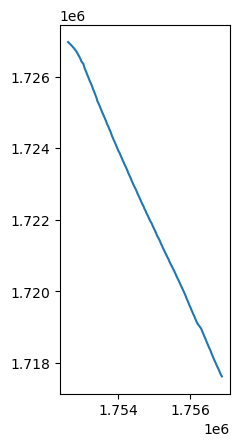

In [6]:
gdf.loc[gdf['Name']==siteName].plot()

In [7]:
newgdf,angle = rotate_gdf(gdf.loc[gdf['Name']==siteName])
x,y = (np.array(arr) for arr in newgdf.iloc[0].geometry.xy)

In [8]:
res = np.hypot(x[1:]-x[:-1],y[1:]-y[:-1]).mean().round(decimals=-2)
if res<100:
    raise ValueError(f"Alongshore spacing ({res}m) too small for CEM (needs >=100m). Downsample your shoreline data")
print(f"dx:{res}m")

dx:100.0m


In [9]:
dx=int(res)
dy=int(res)

In [10]:
angle

114.25822357592527

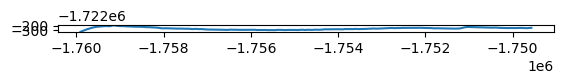

In [11]:
from matplotlib import pyplot as plt
flipud = -1 if "flipud" not in globals() else flipud
fliplr = -1 if "fliplr" not in globals() else fliplr
plt.plot(fliplr*x,flipud*y)
plt.gca().set_aspect('equal')

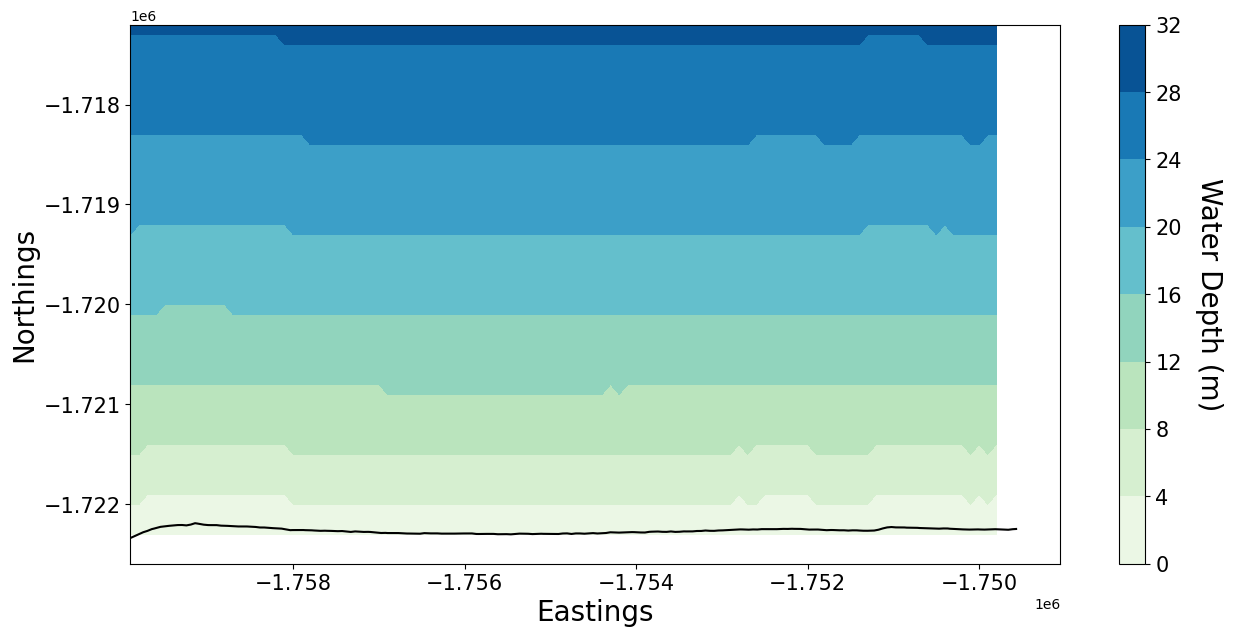

In [12]:
xf, yf = fill_gaps(x, y, 50)
# TODO: Check that sorted points keep seaward direction towards top of screen
# North Core Banks needs flipping
[xg,yg,elev] = shorelinetogrid(fliplr*xf,flipud*yf,dx,dy,plotdata=True)

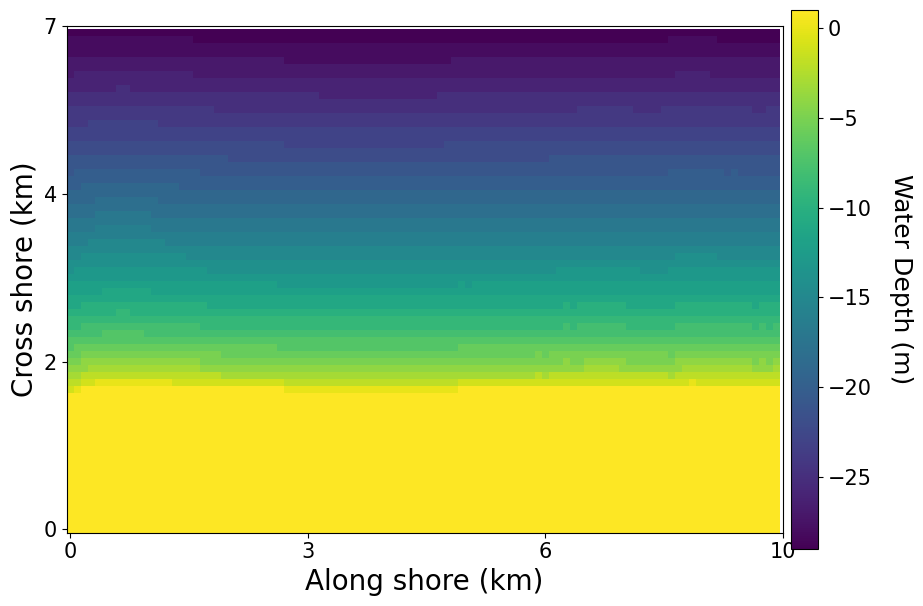

In [13]:
pad = 20
# we need pad to be the masked values
domain = set_domain(elev, pad=pad)
# Also pad the sides by the inlet and outlet bdys
#domain = np.repeat(domain,[pad,*np.ones(domain.shape[1]-2),pad],axis=1)
# visualize updated coastline data
plot_coast(domain,dx,dy)

In [14]:
shelf_slope = find_shelf_slope(domain, dx) ##This should be on the order of 0.001. If not you may need to find this manually
print(f"Shelf slope: {shelf_slope}")
# estimation of shoreface parameters:
shoreface_slope = 4*shelf_slope ## the shoreface is steeper than the shelf
print(f"Shoreface slope: {shoreface_slope}")
shoreface_depth = 10 # depth meters
print(f"Shoreface depth: {shoreface_depth}")

Shelf slope: 0.004130730850322936
Shoreface slope: 0.016522923401291745
Shoreface depth: 10


### 9b. Initialize and Run Model

In [15]:
from pymt.models import Cem, Waves
cem = Cem()
waves = Waves()

#convert wave direction to asymmetry term
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': U, #important param
    'wave_angle_asymmetry': A
    
}

In [2]:
with suppress_c_output():
    initialize_models(params,domain,cem,waves,set_land=True)
land = cem.get_value('land_surface__elevation');
land = land.reshape(  domain.shape  )
#plot_coast(domain,dx,dy)
plot_coast(land,dx,dy)

NameError: name 'suppress_c_output' is not defined

In [17]:
## inputs: time_years, qs_vec (kg/s) - bedload sediment input from a spit
if 'time_years' not in globals():
    time_years=2
T = 365*(time_years/cem.get_value('model__time_step')).astype('int').item()
qs_vec = np.linspace(400,700,T)
n,m = domain.shape
qs_3 = np.zeros((n,m,T))
# qs_3[20,27,:] = qs_vec

xtest is uninitialized!ytest is uninitialized!

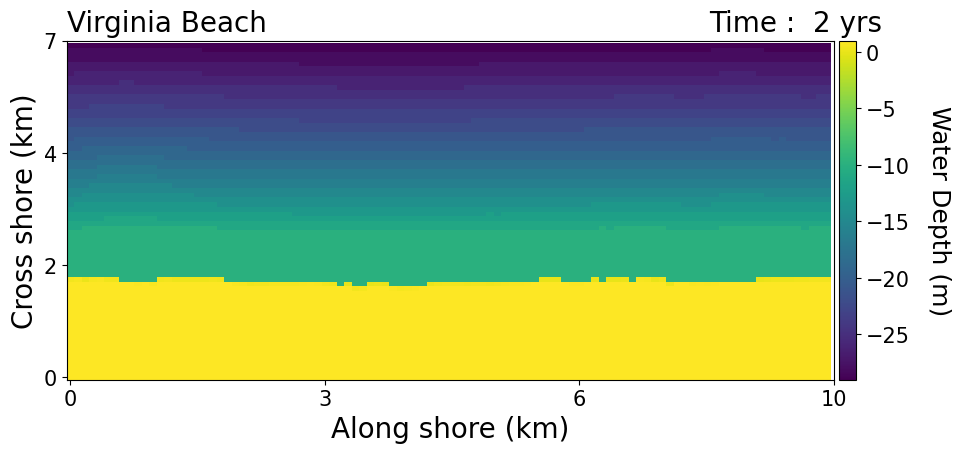

In [18]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
# plot
#run_model_loop(time_years, domain ,cem ,waves, qs_3,animate=True,update_ani_years=1)
anim = vid_model_loop(time_years, domain ,cem ,waves, qs_3, True, 1)#/2, png_dir)
anim.save(f"{siteName}.gif", writer="pillow")
anim